In [97]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- Beta
- Market Cap
- Earnings and Dividend Dates
- Fund/Institutional Holdings  

## Filtering
First, we ignore any delisted stocks, or non-US and Canadian Stocks, then filter by average monthly volume:
  



In [13]:
tickers = pd.read_csv('Tickers_Example.csv')
tickerlist = [tickers.columns[0]]
tickerlist += [i for i in tickers.iloc[:,0]]
startdate = '2023-10-01'
enddate = '2024-09-30'
stockdata = yf.download(tickerlist, start=startdate, end=enddate)
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000

for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    if (t.get_history_metadata())['exchangeName'] not in exchangelist or hist['Volume'].mean() < minvolume or hist['Close'].mean() < minprice:
        tickerlist.remove(ticker)    

[*********************100%***********************]  41 of 41 completed

4 Failed downloads:
['MON', 'RTN', 'AGN', 'CELG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


1.0648682262968254


<BarContainer object of 2 artists>

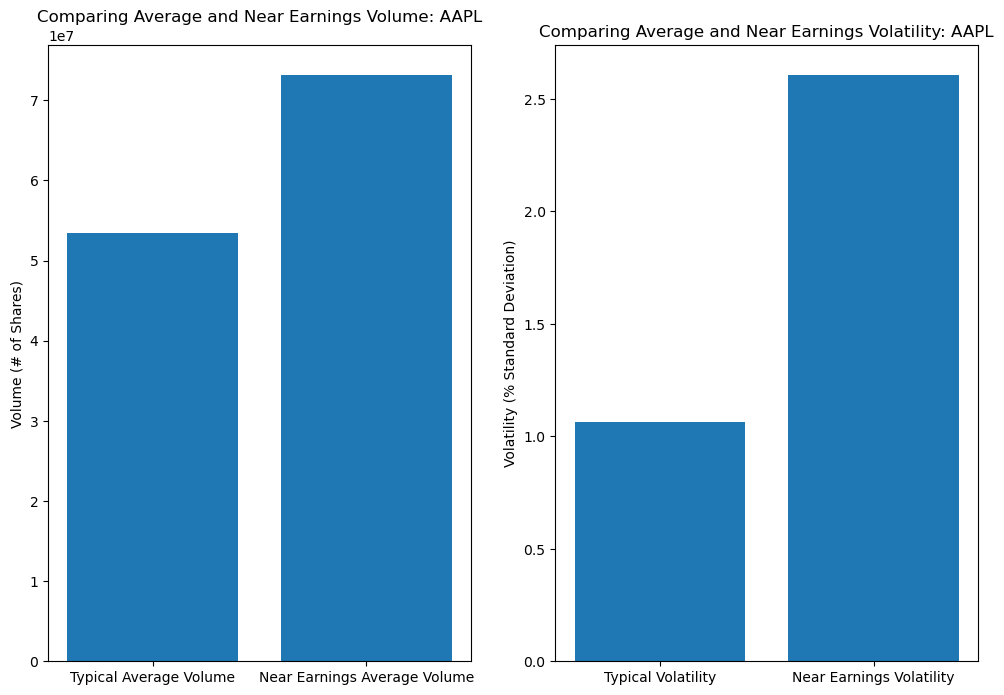

In [94]:
start1='2023-10-01'
end1='2023-11-01'
start2='2024-04-24'
end2='2024-05-05'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [122]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

2024-11-25


## Beta
Beta is a measure of volatility of a security or portfolio compared to the market. A beta of 1.0 indicates that a stock follows the market's returns exactly. In this case, yfinance provides a beta value comparing each stock the S&P500 index. However, as we want to match the average of both the TSX60 and the S&P500, we will calculate beta when compared to the TSX60. Then, we can take the average of the two betas in order to accurately represent the volatility compared to the index used in this assignment.  
  
We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [78]:
tsxprice = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
beta_dict = {}
closedata = stockdata.loc[:, 'Adj Close']
#pre calculate variance of the TSX index to avoid looped computation
tsxpct = tsxprice.pct_change(fill_method=None)
tsxvar = tsxpct.var().iloc[0]

#calculate beta for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(tsxprice.index)
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    #calculate beta with respect to TSX
    beta1 = closepct.cov(tsxpct.iloc[:,0]) / tsxvar
    #fetch beta with respect to SP500
    beta2 = yf.Ticker(ticker).info.get('beta') 
    beta_dict[ticker] = abs(1.0 - (beta1 + (beta2 if beta2 else beta1)) / 2)

[*********************100%***********************]  1 of 1 completed


In [80]:
print('The stocks sorted by closeness to 1.0 are: ')
for t in sorted(beta_dict, key=beta_dict.get, reverse=False):
    print(t, beta_dict[t])

The stocks sorted by closeness to 1.0 are: 
AIG 0.007020386424529068
UPS 0.011397143560423872
ACN 0.03863853946721041
BK 0.03901844182473324
UNP 0.06783171134318278
AMZN 0.08500735473387966
AAPL 0.10079884557436536
TXN 0.13161826360272855
RY.TO 0.13576631776083803
TD.TO 0.13905730404579497
BLK 0.20768128270713593
AXP 0.2118477612945293
CAT 0.2727220927641658
USB 0.33476286679101586
BA 0.34273274178105306
BAC 0.3553168151963777
QCOM 0.3791578100996622
C 0.4035430179756432
T.TO 0.4194668623417658
PFE 0.4414258709464143
MO 0.48138576097116315
PYPL 0.4846358464529774
LLY 0.4867046466249705
PM 0.501753810924371
ABT 0.5170228810947448
BMY 0.5263154744483574
ABBV 0.5529770641027439
BIIB 0.5771155797098365
KO 0.5963532474289345
UNH 0.601832106064732
LMT 0.6408911812196006
PEP 0.6603997625167022
MRK 0.6967549952373611
PG 0.7792029723077335
CL 0.7981922076188871
SHOP.TO 1.3542786004030116
